Cargando: application_.parquet...
-> Cargado exitosamente. Shape: (307511, 122)
Cargando: bureau.parquet...
-> Cargado exitosamente. Shape: (1716428, 17)
Cargando: previous_application.parquet...
-> Cargado exitosamente. Shape: (1670214, 37)

--- Vista de la Tabla Principal ---
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750

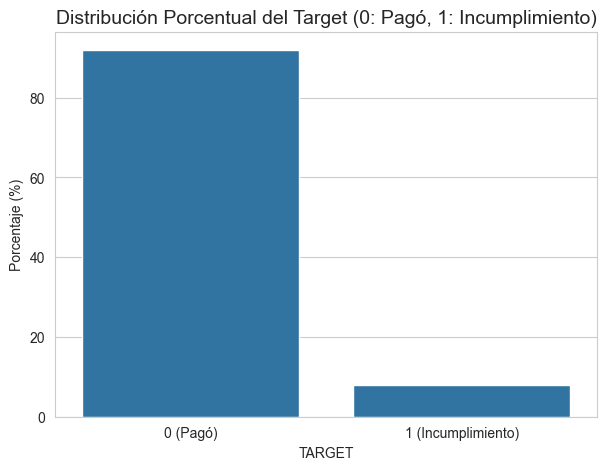


¡ALERTA!: La clase minoritaria (Incumplimiento) representa solo el 8.07% del total.

--- Relación con Bureau (Créditos en otras instituciones) ---
Clientes con un solo crédito previo: 41520 clientes
Clientes con más de 10 créditos previos: 38328 clientes
Máximo de créditos previos por cliente: 116


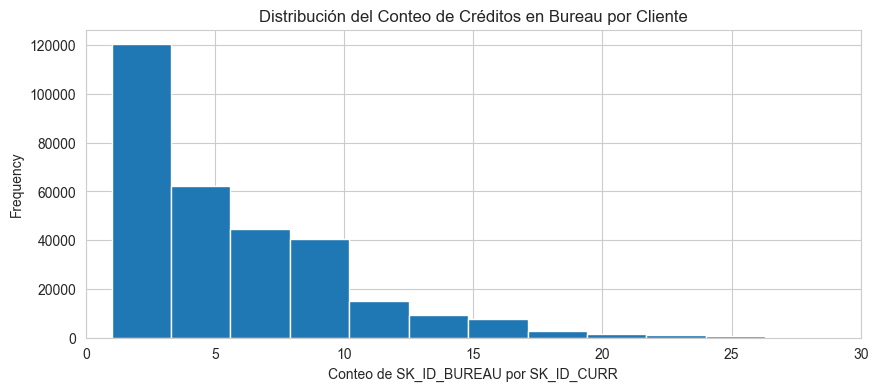


--- Relación con Solicitudes Previas (Home Credit) ---
Máximo de solicitudes previas por cliente: 77
Media de solicitudes previas: 4.93

Tipos de contrato más comunes en solicitudes previas:
NAME_CONTRACT_TYPE
Cash loans         0.447579
Consumer loans     0.436561
Revolving loans    0.115652
XNA                0.000207
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de visualización
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
# ==========================================================
# 📌 CONFIGURACIÓN DE RUTA
# ==========================================================
# Si tus archivos están en la misma carpeta que el script, usa './'
# Si están en una subcarpeta llamada 'data', usa './data/'
#DATA_PATH = '../data/' # Ajusta esta ruta según la ubicación de tus archivos .parquet

DATA_PATH = '../data/' # Ajustar si la ruta de tus archivos Parquet es diferente

def load_parquet_file(filename):
    """Carga un archivo parquet dado su nombre de archivo."""
    file_path = DATA_PATH + filename
    try:
        print(f"Cargando: {filename}...")
        df = pd.read_parquet(file_path)
        print(f"-> Cargado exitosamente. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"ERROR: No se pudo cargar {filename}. Asegúrate de que existe. Error: {e}")
        return None

# Cargar las tablas principales que utilizaremos para el EDA inicial
df_app = load_parquet_file('application_.parquet') # Contiene train y test, incluyendo TARGET (nulos en test)
df_bureau = load_parquet_file('bureau.parquet')
df_prev = load_parquet_file('previous_application.parquet')

if df_app is not None:
    print("\n--- Vista de la Tabla Principal ---")
    print(df_app.head())
    print("\n--- Tipos de Datos (Muestras) ---")
    print(df_app.dtypes.sample(20)) # Muestra 20 tipos de datos

if df_app is not None and 'TARGET' in df_app.columns:
    # Filtramos solo los datos de entrenamiento (donde TARGET no es nulo)
    df_train = df_app[df_app['TARGET'].notna()]
    
    target_counts = df_train['TARGET'].value_counts(normalize=True) * 100
    
    print("\n--- Distribución de la Variable TARGET (Incumplimiento) ---")
    print(target_counts)
    
    plt.figure(figsize=(7, 5))
    sns.barplot(x=target_counts.index, y=target_counts.values)
    plt.title('Distribución Porcentual del Target (0: Pagó, 1: Incumplimiento)', fontsize=14)
    plt.xlabel('TARGET')
    plt.ylabel('Porcentaje (%)')
    plt.xticks(ticks=[0, 1], labels=['0 (Pagó)', '1 (Incumplimiento)'])
    plt.show()

    # Confirmamos el desbalance
    print(f"\n¡ALERTA!: La clase minoritaria (Incumplimiento) representa solo el {target_counts[1]:.2f}% del total.")
    
#
if df_bureau is not None:
    print("\n--- Relación con Bureau (Créditos en otras instituciones) ---")
    
    # 1. ¿Cuántos créditos previos tiene cada cliente? (SK_ID_CURR)
    bureau_counts = df_bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
    
    print(f"Clientes con un solo crédito previo: {np.sum(bureau_counts == 1)} clientes")
    print(f"Clientes con más de 10 créditos previos: {np.sum(bureau_counts > 10)} clientes")
    print(f"Máximo de créditos previos por cliente: {bureau_counts.max()}")
    
    plt.figure(figsize=(10, 4))
    bureau_counts.plot(kind='hist', bins=50, title='Distribución del Conteo de Créditos en Bureau por Cliente')
    plt.xlabel('Conteo de SK_ID_BUREAU por SK_ID_CURR')
    plt.xlim(0, 30)
    plt.show()

if df_prev is not None:
    print("\n--- Relación con Solicitudes Previas (Home Credit) ---")

    # 1. ¿Cuántas solicitudes previas tiene cada cliente? (SK_ID_CURR)
    prev_counts = df_prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
    
    print(f"Máximo de solicitudes previas por cliente: {prev_counts.max()}")
    print(f"Media de solicitudes previas: {prev_counts.mean():.2f}")
    
    # 2. Tipos de Contrato más comunes en solicitudes previas
    print("\nTipos de contrato más comunes en solicitudes previas:")
    print(df_prev['NAME_CONTRACT_TYPE'].value_counts(normalize=True).head())

